# Classical Autoencoder Network for Seismic Trace Reconstruction

Seismic trace data is often high dimensional, and can also contain noisy signals or missing measurements, which may cause difficulties for data processing. Autoencoders are highly useful in this regard, and can be utilized for both reconstructing data using a lower dimensionality, as well as reducing the noise and reproducing a cleaner signal, while still retaining the structure of the signals themselves. 

In this notebook, we provide a classical counterpart to the quantum autoencoder, and detail how this can be trained for seismic signal and trace reconstruction. Alongside our quantum autoencoder model, we train and reconstruct a short snippet of a signal taken from the Volve dataset. We later train and test the autoencoder both on synthetically produced data, obtained from [this](https://github.com/vishaldas/CNN_based_impedance_inversion/blob/master/Volve_field_example) github repository, as well as some actual measurements from the [Volve field dataset](https://www.equinor.com/energy/volve-data-sharing). The aforementioned repository is an addition to Vishal Das' [paper](https://library.seg.org/doi/abs/10.1190/geo2018-0838.1) on using CNN's for seismic impedance inversion. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import math
from random import randint
from shutil import copyfile
from numpy import genfromtxt

import torch 
import torch.nn as nn
import torch.autograd 
from torch.autograd import Variable
from random import randint
import torch.nn.functional as F
import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# loading the data
seismic_data = genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')
source_statistical = genfromtxt('statistical_source_wavelet.txt', delimiter='	') #Ricker wavelet for convolution

time_seismic = -np.round(seismic_data[:,0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)

seismic_trace = seismic_data[unique_indices,1]

start_time = 2340.0
end_time = 2500.0

seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
# Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

In [3]:
# seismic trace cropped is already normalized so no need to do that again, create a tensor for use in the autoencoder
strace_tensor = torch.FloatTensor(seismic_trace_cropped)

In [4]:
class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, 30),
           nn.ReLU(),
           nn.Linear(30, encoding_dim),
           nn.ReLU()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, 30),
           nn.ReLU(),
           nn.Linear(30, input_size),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.43it/s]

Epoch [1/100], Loss: 0.0684
Epoch [6/100], Loss: 0.0634
Epoch [11/100], Loss: 0.0527
Epoch [16/100], Loss: 0.0307
Epoch [21/100], Loss: 0.0148
Epoch [26/100], Loss: 0.0070
Epoch [31/100], Loss: 0.0025
Epoch [36/100], Loss: 0.0020
Epoch [41/100], Loss: 0.0012
Epoch [46/100], Loss: 0.0007
Epoch [51/100], Loss: 0.0005
Epoch [56/100], Loss: 0.0003
Epoch [61/100], Loss: 0.0002
Epoch [66/100], Loss: 0.0002
Epoch [71/100], Loss: 0.0001
Epoch [76/100], Loss: 0.0001
Epoch [81/100], Loss: 0.0001
Epoch [86/100], Loss: 0.0001
Epoch [91/100], Loss: 0.0000
Epoch [96/100], Loss: 0.0000


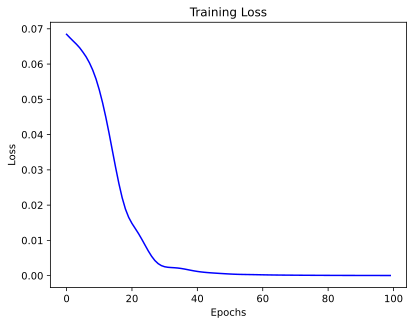

In [5]:
torch.manual_seed(42)

input_size = len(seismic_trace_cropped)
encoding_dim = 15
model = Autoencoder (input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
epochs = 100 # 100 epochs is overkill but also the approximation/reconstruction is very clean

loss_list = []

for epoch in tqdm.trange (epochs):
    outputs = model(strace_tensor)
    loss = criterion(outputs, strace_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch%5 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

reconstructed = model(strace_tensor)

plt.title("Training Loss")
plt.plot(loss_list, 'b')
plt.xlabel("Epochs")
plt.ylabel("Loss"),
plt.show()

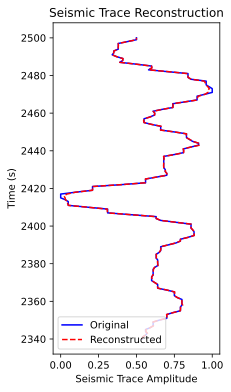

Mean Squared Error (MSE): 3.684754913484123e-05
R-squared (R2) Score: 0.9992310747061245
Mean Absolute Error (MAE): 0.0025285686422949274
Accuracy (within threshold 0.01): 95.65%


In [6]:
plt.figure(figsize=(3, 6))
plt.title("Seismic Trace Reconstruction")
t = np.arange(0, 161*1e-3, 1e-3)
# in seismic trace plots, it is convention to plot time on the y axis
plt.plot(strace_tensor, time_cropped, 'b', label="Original")
plt.plot(reconstructed.detach().numpy(), time_cropped, 'r--', label = "Reconstructed")
plt.xlabel("Seismic Trace Amplitude")
plt.ylabel("Time (s)")
plt.legend(loc="lower left")
plt.show()

mse = mean_squared_error(seismic_trace_cropped, reconstructed.detach().numpy())
r2 = r2_score(seismic_trace_cropped, reconstructed.detach().numpy())
mae = mean_absolute_error(seismic_trace_cropped, reconstructed.detach().numpy())
# Custom accuracy metric
threshold = 0.01
accuracy = np.mean(np.abs(seismic_trace_cropped -reconstructed.detach().numpy()) <= threshold) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Accuracy (within threshold {threshold}): {accuracy:.2f}%")

In [7]:
Ip = np.loadtxt('Ip_exported.txt')
Ip_reshape = np.reshape(Ip, ((151,151,160)), order='F')

In [8]:
# Trace by trace normalization and convolution - from Vishal Das repo
ss_new = np.zeros(Ip_reshape.shape)
Ip_normalized = np.zeros(Ip_reshape.shape)
for i in range(Ip_reshape.shape[0]):
    for j in range(Ip_reshape.shape[1]):
        Ip_trace = Ip_reshape[i,j,:]
        Ip_normalized[i,j,:] = (Ip_trace - np.min(Ip_trace))/(np.max(Ip_trace) - np.min(Ip_trace))
        r0_trace = 0.5*np.diff(np.log(Ip_trace))
        r0_trace = np.insert(r0_trace,0, 0)
        ss_trace = np.convolve(r0_trace, source_statistical[:,1], mode='same')
        ss_new[i,j,:] = (ss_trace - np.min(ss_trace))/(np.max(ss_trace) - np.min(ss_trace))

In [9]:


# create a training and testing data, referenced from Vishal Das repository

# Testing dataset created near the area of the well
indx_i_well_start, indx_i_well_end = 20, 45
indx_j_well_start, indx_j_well_end = 32, 54

seismic_test = ss_new[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
seismic_test = torch.FloatTensor(seismic_test.reshape(-1, seismic_test.shape[-1]))

# Flatten rest of indices 
ss_data_rest = ss_new[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):ss_new.shape[0]], :, :]
ss_data_rest = ss_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):ss_new.shape[1]],:]
ss_data_rest = ss_data_rest.reshape(-1, ss_data_rest.shape[-1])

# Selecting randomly training dataset
samples = 750 # Seismic samples considered
np.random.seed(42) # For replication of results
indxRand = [randint(0,ss_data_rest.shape[0]-1) for p in range(0,samples)] # choosing random indices to create the training set

seismic_train = (ss_data_rest[indxRand, :])
seismic_train = torch.FloatTensor(np.reshape(seismic_train, (seismic_train.shape[0], seismic_train.shape[1])))

In [10]:
class Autoencoder2(nn.Module):
   def __init__(self, input_size, encoding_dim):
       super(Autoencoder2, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, 80),
           nn.ReLU(),
           nn.Linear(80, encoding_dim),
           nn.ReLU()
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, 80),
           nn.ReLU(),
           nn.Linear(80, input_size),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

In [11]:
torch.manual_seed(42)

input_size = len(seismic_train.T)
encoding_dim = 20
model = Autoencoder2 (input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
epochs = 200

train_loss = []
val_loss = []

for epoch in tqdm.trange (epochs):
    outputs = model(seismic_train)
    loss = criterion(outputs, seismic_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if epoch%10 == 9:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

 22%|█████████████████▏                                                              | 43/200 [00:00<00:00, 213.36it/s]

Epoch [10/200], Loss: 0.0604
Epoch [20/200], Loss: 0.0377
Epoch [30/200], Loss: 0.0281
Epoch [40/200], Loss: 0.0229
Epoch [50/200], Loss: 0.0182


 46%|████████████████████████████████████▊                                           | 92/200 [00:00<00:00, 232.45it/s]

Epoch [60/200], Loss: 0.0164
Epoch [70/200], Loss: 0.0140
Epoch [80/200], Loss: 0.0120
Epoch [90/200], Loss: 0.0105
Epoch [100/200], Loss: 0.0093
Epoch [110/200], Loss: 0.0086


 70%|███████████████████████████████████████████████████████▎                       | 140/200 [00:00<00:00, 230.58it/s]

Epoch [120/200], Loss: 0.0078
Epoch [130/200], Loss: 0.0073
Epoch [140/200], Loss: 0.0067
Epoch [150/200], Loss: 0.0064
Epoch [160/200], Loss: 0.0061


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 227.97it/s]

Epoch [170/200], Loss: 0.0059
Epoch [180/200], Loss: 0.0057
Epoch [190/200], Loss: 0.0055
Epoch [200/200], Loss: 0.0054


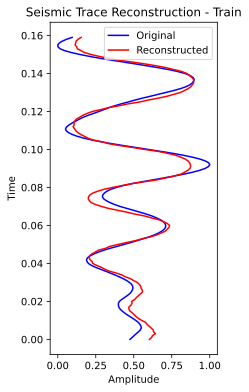

Mean Squared Error (MSE): 0.004106842912733555
Mean Absolute Error (MAE): 0.053180158138275146
R-squared (R2) Score: 0.9337994954958382


In [12]:
with torch.no_grad():
    reconstructed = model(seismic_train)
reconstructedplot = reconstructed.detach().numpy().transpose()[:, 0]

time = np.arange(0, seismic_train.shape[1]*1e-3, 1e-3)
plt.figure(figsize=(3, 6))
plt.title("Seismic Trace Reconstruction - Train")
plt.plot(seismic_train.detach().numpy().transpose()[:, 0], time, 'b', label="Original")
plt.plot(reconstructedplot, time, 'r', label="Reconstructed")
plt.legend()
plt.xlabel("Amplitude")
plt.ylabel("Time")
plt.show()

mse_train = mean_squared_error(seismic_train.detach().numpy().transpose()[:, 0], reconstructedplot)
r2_train = r2_score(seismic_train.detach().numpy().transpose()[:, 0], reconstructedplot)
mae_train = mean_absolute_error(seismic_train.detach().numpy().transpose()[:, 0], reconstructedplot)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")
print(f"R-squared (R2) Score: {r2_train}")

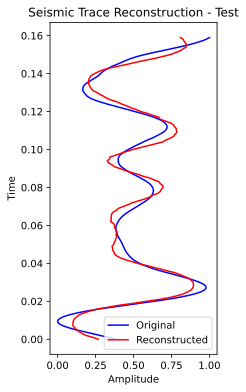

Mean Squared Error (MSE): 0.005073681939393282
Mean Absolute Error (MAE): 0.06001530960202217
R-squared (R2) Score: 0.9022671727921434


In [13]:
with torch.no_grad():
    recon2 = model(seismic_test)
# We plot and calculate errors for a randomly chosen sample 
recon2plot = recon2.detach().numpy().transpose()[:, 7]
plt.figure(figsize=(3, 6))
plt.title("Seismic Trace Reconstruction - Test")
plt.plot(seismic_test.detach().numpy().transpose()[:, 7], time, 'b', label="Original")
plt.plot(recon2plot, time, 'r', label="Reconstructed")
plt.xlabel("Amplitude")
plt.ylabel("Time")
plt.legend()
plt.show()

mse_test = mean_squared_error(seismic_test.detach().numpy().transpose()[:, 7], recon2plot)
r2_test = r2_score(seismic_test.detach().numpy().transpose()[:, 7], recon2plot)
mae_test = mean_absolute_error(seismic_test.detach().numpy().transpose()[:, 7], recon2plot)

print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R-squared (R2) Score: {r2_test}")

In [14]:
# testing on the original data from the Volve field dataset which was used earlier,
# here, we split the earlier seismic_trace array into 3 subsections and test the model on them.
strace1 = torch.FloatTensor(seismic_trace[0:160])
with torch.no_grad():
    recon_1 = model(strace1)
strace2 = torch.FloatTensor(seismic_trace[80:240])
with torch.no_grad():
    recon_2 = model(strace2)
strace3 = torch.FloatTensor(seismic_trace[160:320])
with torch.no_grad():
    recon_3 = model(strace3)

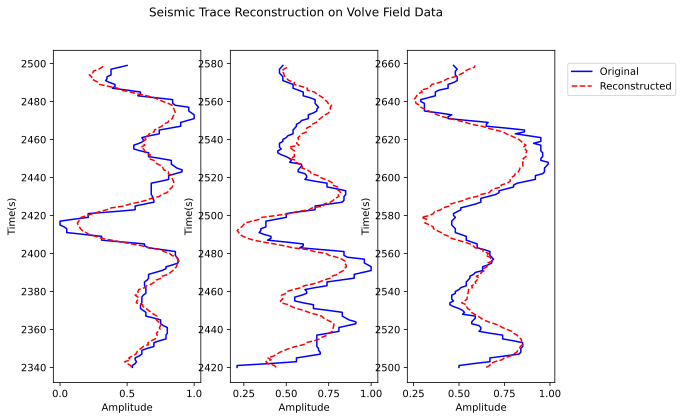

In [15]:
plot1 = recon_1.detach().numpy().transpose()
plot2 = recon_2.detach().numpy().transpose()
plot3 = recon_3.detach().numpy().transpose()
t1 = np.arange(2340, 2500, 1)
t2 = np.arange(2420, 2580, 1)
t3 = np.arange(2500, 2660, 1)

fig, axs = plt.subplots(1, 3, figsize=(9, 6), sharey=False)
fig.suptitle(f"Seismic Trace Reconstruction on Volve Field Data")
# plt.figure(figsize=(9, 6))
axs[0].plot(strace1, t1, 'b', label="Original")
axs[0].plot(plot1, t1, 'r--', label="Reconstructed")
axs[0].set_xlabel("Amplitude")
axs[0].set_ylabel("Time(s)")
axs[1].plot(strace2, t2, 'b', label="Original")
axs[1].plot(plot2, t2, 'r--', label="Reconstructed")
axs[1].set_xlabel("Amplitude")
axs[1].set_ylabel("Time(s)")
axs[2].plot(strace3, t3, 'b', label="Original")
axs[2].plot(plot3, t3, 'r--', label="Reconstructed")
axs[2].set_xlabel("Amplitude")
axs[2].set_ylabel("Time(s)")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.92, 0.85), loc=2, borderaxespad=0.)

plt.show()